# Simple Heavy snowfall & blizzards workflow

Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/DROUGHTS/main?labpath=DROUGHTS_notebook_2.ipynb) to launch this workflow on MyBinder. 

This is the first and simplest snow workflow.  

## Risk assessment methodology

The approach is to visualise the exposed vulnerable population to the heavy snowfall and blizzards. This can be done by overlying the heavy snowfall and blizzard Indicator, and population data. 

### Blizzard  

A blizzard is a severe storm condition defined by low temperature, sustained wind or frequent wind gust and considerable precipitating or blowing snow. For blizzard conditions we propose the use of following impact indicator: Tmean  ≤ 0 oC, Rs (snow amount) ≥ 10 cm and Wg (wind gust) ≥ 17 m/s ( Vajda et al., 2014). This impact indicator was defined taking into account the exposure of critical infrastructure, i.e., roads, rails, power lines, telecommunication to the hazard and is based on an extensive literature review, media reports, surveys conducted with European CI operators and case studies. 

### Heavy Snow 

Heavy snowfall may cause many disruptions and impacts in various sectors; however, the impacts and consequences of this hazard depend on the affected sector, infrastructure and also preparedness of society that varies over Europe.  For example, already a few centimeters of snow can disrupt road traffic, but doesn’t normally cause any harm to energy infrastructure. Many weather services have three warning levels based on the severity of expected impacts, which are typically different for different sectors of infrastructure. There is a large variation in the national warning criteria or thresholds.

Similarly to blizzard, the impact indicators for heavy snowfall were defined taking into account the exposure of critical infrastructure, i.e., roads, rails, power lines, telecommunication to the hazard and is based on an extensive literature review, media reports, surveys conducted with European CI operators and case studies. The qualitative description of the two-level thresholds are:

** 1st threshold:** Some adverse impacts are expected, their severity depends on the resilience of the system, transportation is mainly affected.

** 2nd threshold:**  The weather phenomena are so severe that is likely that adverse impact will occur, CI system is seriously impacted.

This code calculates the Annual probability (%) of a blizzard and heavy snowfall during the specified period and a region of interest.



Exposure data  
Exposure is assessed by overlaying the European population density map at 1000 m resolution using the [Global Human Settlement Population dataset](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop) dataset. 

## Preparation work
### Load libraries

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download and unzip the data
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format
- [xarray](https://docs.xarray.dev/en/stable/) - To process the data and prepare it for damage calculation
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps
- [matplotlib](https://matplotlib.org/) - For plotting as well
- [cdsapi](https://pypi.org/project/cdsapi/) - To access the  CDS data
- [xclim](https://xclim.readthedocs.io/en/stable/installation.html) - To correct the required data units
- [urllib](https://docs.python.org/3/library/urllib.html/) - modules to handle URL 


In [1]:
import os
import pooch

import numpy as np
import rasterio
from pathlib import Path
import rioxarray as rxr
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cdsapi
import xclim as xc
import pandas as pd
from urllib.request import urlopen
from glob import glob

/Users/poladesu/anaconda3/lib/python3.10/site-packages/xclim/indices/fire/_cffwis.py:218: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _day_length(lat: int | float, mth: int):  # pragma: no cover
/Users/poladesu/anaconda3/lib/python3.10/site-packages/xclim/indices/fire/_cffwis.py:238: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _day_length_factor(lat:

### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.  
Next cell will create the directory called 'snow_workflow' in the same directory where this notebook is saved.

The cell after will create the **data** directory inside the **snow_workflow**.

In [2]:
workflow_folder = 'snow_workflow'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

In [3]:
data_dir = os.path.join(workflow_folder,'data')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## Download data

In this workflow, we will have a mix of data available to download through API and the data that must be manually downloaded from the website.

Since there is no API to download population data, we can use **[pooch](https://www.fatiando.org/pooch/latest/index.html)** library to download and unzip it. 

Pooch will check if the zip file already exists by comparing the hash of the file with what is stored in the default and only download it if it is not already there.

### Population data
First we need the information on the population. We will download it from the JRC data portal.  
Once the data is downloaded and unzipped, Pooch will list the content of the directory with the data.  

In this example we are using population data from JRC data portal - the Global Human Settlement Layer (GHSL). Note that this dataset is available in 100m resolution as well.

We are downloading global data, but it is also available in regional grid.

In [4]:
url = 'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2030_GLOBE_R2023A_54009_1000/V1-0/GHS_POP_E2030_GLOBE_R2023A_54009_1000_V1_0.zip'

pooch.retrieve(
    url=url,
    known_hash='a47d7d587b2607c62bbffed4b05521ca9bd7be7d431bcfac7e33286954a68d3c',
    path=data_dir,
    processor=pooch.Unzip(extract_dir=''))

['/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/GHS_POP_E2030_GLOBE_R2023A_54009_1000_V1_0.tif',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/.DS_Store',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/GHSL_Data_Package_2023.pdf',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/GHS_POP_GLOBE_R2023A_input_metadata.xlsx',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/snow6Prob_annual_mean.nc',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/snow25Prob_annual_mean.nc',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/BdayCount_AnaProb_mean.nc',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/GHS_POP_E2030_GLOBE_R2023A_54009_1000_V1_0.tif.ovr',
 '/Users/poladesu/D_Drive/Prog_FMI/dmin_CLIMAAX/snow_workflow/data/6011302b72827340cb7b024ff736b1e6-GHS_POP_E2030_GLOBE_R2023A_54009_1000_V1_0.zip']

The zip file contains data, as well as metadata and the documentation in the pdf file.

### The Heavy snowfall & blizzards Indicator

We downloaded this dataset using the CDS API from the Copernicus Climate Data Store (https://cds.climate.copernicus.eu/#!/home). We require several variables to calculate these indicator, which are at an hourly frequency. Consequently, this analysis is limited to the data period from 1991 to 2010."

In [5]:
c = cdsapi.Client()

# Lat Lon for Finland
area = [80, -10, 20, 45,]
#area = [70, 20, 60, 30,]
day_range=np.arange(1,32)
month_range=np.array((1,2,3,10,11,12))
varnames=['2m_temperature','10m_wind_gust_since_previous_post_processing','snow_depth','snow_density']
dataset = 'reanalysis-era5-single-levels'

# API request
params = {'format': 'netcdf',
        'product_type': 'reanalysis',
        'variable': varnames,
        'year': list(map(str, range(1991, 2010))),
        'month': list(map("{:02d}".format, range(1,13))),
        'time': ['00:00', '06:00', '12:00', '18:00', ],
        'day': list(np.char.zfill(list(map(str, day_range)),2)),
        'grid': [0.25, 0.25],
        'area':area,}

# retrieve the location of the file
fl = c.retrieve(dataset, params)

# load into memory
with urlopen(fl.location) as f:
    ds = xr.open_dataset(f.read())

# Convert Temperature unit 
ds['t2m']  = xc.units.convert_units_to(ds.t2m, "degC")
ds['snow_depth'] = 1000 * ds.sd / ds.rsn
ds = ds.drop(['sd','rsn'])
ds['snow_depth'] = ds.snow_depth.assign_attrs(units="m", description="snow depth")
ds['snow_depth'] = xc.units.convert_units_to(ds.snow_depth, "cm")
print(ds)

#| Calculate hourly to daily data 
tas_day        = ds.t2m.resample(time='24H').mean('time')
wspd_day       = ds.fg10.resample(time='24H').max('time')
snow_depth_day = ds.snow_depth.resample(time='24H').mean('time')

#| Define thresholds 
lim_tas=0.
lim_pr=10.
lim_gust=17.
lim_snow = 10.
lim_snow6 = 6.
lim_snow25 = 25.

time_slice = slice("2021-12-01", "2021-12-05")
lat_bound  = slice(80, 60)
lon_bound  = slice(100, 170)

BdayCount_anaProb = ((tas_day < lim_tas) * (snow_depth_day > lim_snow) * (wspd_day > lim_gust)).groupby('time.year').mean('time')
del tas_day, wspd_day

BdayCount_anaProb = BdayCount_anaProb.where(BdayCount_anaProb != 0.)
BdayCount_anaProb = BdayCount_anaProb.assign_attrs(units="%", long_name="Annual probability of blizzard days")
BdayCount_anaProb = BdayCount_anaProb.to_dataset(name='blizzard_days')
BdayCount_anaProb_mean = BdayCount_anaProb.mean('year')
BdayCount_anaProb_mean = BdayCount_anaProb_mean * 1000.
BdayCount_anaProb_mean.to_netcdf(path=os.path.join(data_dir, "BdayCount_AnaProb_mean.nc"))
del BdayCount_anaProb

#| Probability of occurence in % for snowfall > 6cm

snow6Prob_annual = (snow_depth_day > 6.).groupby('time.year').mean('time')
snow6Prob_annual = snow6Prob_annual.where(snow6Prob_annual != 0.)
snow6Prob_annual = snow6Prob_annual.assign_attrs(units="%", long_name="Annual probability of snow days")
snow6Prob_annual = snow6Prob_annual.to_dataset(name='snow_days')
snow6Prob_annual = snow6Prob_annual * 100.
snow6Prob_annual_mean = snow6Prob_annual.mean('year')
snow6Prob_annual_mean.to_netcdf(path=os.path.join(data_dir, "snow6Prob_annual_mean.nc"))
del snow6Prob_annual

#| Probability of occurence in % for snowfall > 25cm

snow25Prob_annual = (snow_depth_day > 25.).groupby('time.year').mean('time')
snow25Prob_annual = snow25Prob_annual.where(snow25Prob_annual != 0.)
snow25Prob_annual = snow25Prob_annual.assign_attrs(units="%", long_name="Annual probability of snow days")
snow25Prob_annual = snow25Prob_annual.to_dataset(name='snow_days')
snow25Prob_annual = snow25Prob_annual * 100.
snow25Prob_annual_mean = snow25Prob_annual.mean('year')
snow25Prob_annual_mean.to_netcdf(path=os.path.join(data_dir, "snow25Prob_annual_mean.nc"))
del snow25Prob_annual

2023-09-08 12:03:00,685 INFO Welcome to the CDS
2023-09-08 12:03:00,687 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-09-08 12:03:00,954 INFO Request is completed


<xarray.Dataset>
Dimensions:     (longitude: 221, latitude: 241, time: 27760)
Coordinates:
  * longitude   (longitude) float32 -10.0 -9.75 -9.5 -9.25 ... 44.5 44.75 45.0
  * latitude    (latitude) float32 80.0 79.75 79.5 79.25 ... 20.5 20.25 20.0
  * time        (time) datetime64[ns] 1991-01-01 ... 2009-12-31T18:00:00
Data variables:
    t2m         (time, latitude, longitude) float32 -8.602 -8.507 ... 20.11
    fg10        (time, latitude, longitude) float32 ...
    snow_depth  (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-06 14:26:40 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...


Note that now we have a directory **snow_workflow/data** where all the zip files and unzipped files are (or should be).  
We can list all the files in the **data_dir** using the os library.  

In [6]:
with os.scandir(data_dir) as entries:
    for entry in entries:
        print(entry.name)

GHS_POP_E2030_GLOBE_R2023A_54009_1000_V1_0.tif
.DS_Store
GHSL_Data_Package_2023.pdf
GHS_POP_GLOBE_R2023A_input_metadata.xlsx
snow6Prob_annual_mean.nc
snow25Prob_annual_mean.nc
BdayCount_AnaProb_mean.nc
GHS_POP_E2030_GLOBE_R2023A_54009_1000_V1_0.tif.ovr
6011302b72827340cb7b024ff736b1e6-GHS_POP_E2030_GLOBE_R2023A_54009_1000_V1_0.zip


## Explore the data
Now that we have downloaded and unpacked the needed data, we can have a look what is inside.  

### Annual probability plot of indicator


Text(0.0, 1.0, 'Annual probability (%) of blizzard ')

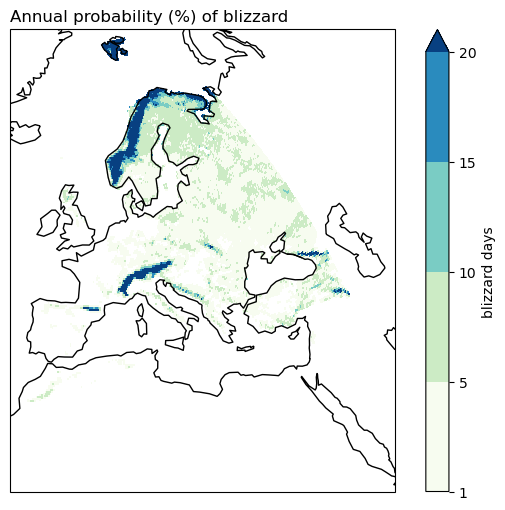

In [7]:
fig = plt.figure(figsize=(8, 6))
p_levels = [ 1,5,10,15,20]

p = BdayCount_anaProb_mean.blizzard_days.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
    levels=p_levels, 
    cbar_kwargs={"label": "blizzard days"},
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
)
p.axes.coastlines()
plt.title('Annual probability (%) of blizzard ', loc = "left")


Text(0.0, 1.0, 'Annual probability (%) of snowfall exceeding 6 cm  ')

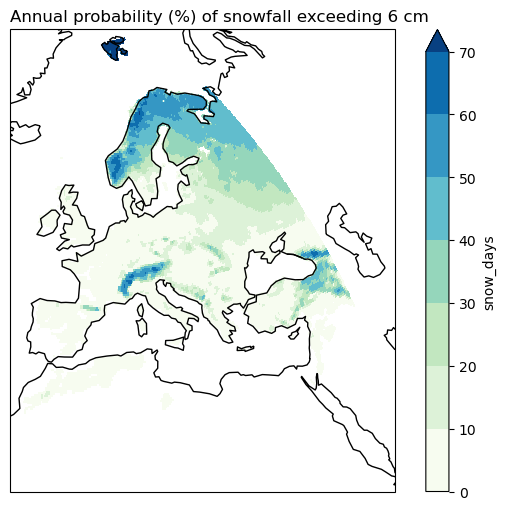

In [8]:
fig = plt.figure(figsize=(8, 6))
p_levels = [0, 10,20,30,40,50,60,70]

p = snow6Prob_annual_mean.snow_days.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
    levels=p_levels, 
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
)
p.axes.coastlines()
plt.title('Annual probability (%) of snowfall exceeding 6 cm  ', loc = "left")


Text(0.0, 1.0, 'Annual probability (%) of snowfall exceeding 25 cm  ')

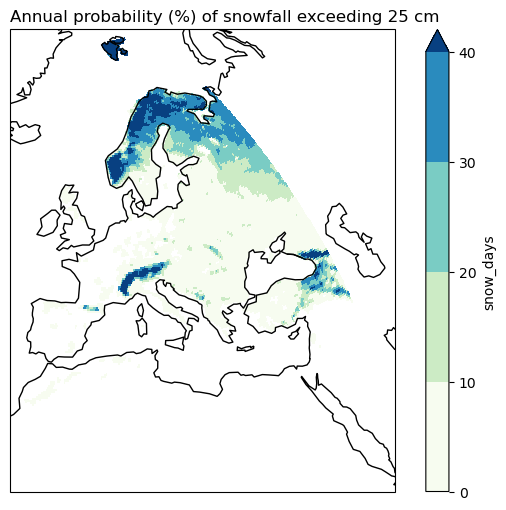

In [9]:
fig = plt.figure(figsize=(8, 6))
p_levels = [0,10,20,30,40]

p = snow25Prob_annual_mean.snow_days.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
    levels=p_levels, 
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
)
p.axes.coastlines()
plt.title('Annual probability (%) of snowfall exceeding 25 cm  ', loc = "left")


### Population data
Population data is in file with filename: GHS_POP_E2030_GLOBE_R2023A_54009_1000_V1_0.tif

We can use rioxaray to load this file.

In [10]:
filename_population = f'{data_dir}/GHS_POP_E2030_GLOBE_R2023A_54009_1000_V1_0.tif'

population = rxr.open_rasterio(filename_population)
population

<xarray.DataArray (band: 1, y: 18000, x: 36082)>
[649476000 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -1.804e+07 -1.804e+07 ... 1.804e+07 1.804e+07
  * y            (y) float64 9e+06 8.998e+06 8.998e+06 ... -8.998e+06 -9e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        452635.11543083
    STATISTICS_MEAN:           61.892180872876
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         767.17038013196
    STATISTICS_VALID_PERCENT:  21.26
    _FillValue:                -200.0
    scale_factor:              1.0
    add_offset:                0.0

## Process the data

In this workflow, we want to overlay the population data on snowfall and blizzard indicators to understand better where these indicators affect densely populated areas.

:::{hint} Take a closer look at the dimensions and coordinates of our two data objects.
- The population dataset contains two variables, the **cdinx** which is the data variable, and **3035** which has the informaiton about the projection.
- Notice that population data has **x** and **y** as spatial dimensions, while ERA5 has **lat** and **lon**
- The projections and resolutions are very different.

:::

To be able to plot these two datasets together we must have them in the same projection and zoom to the same area.  


### Reproject the datasets 

We will need to select the area of interest. We can reproject both in EPSG:4326 projection. 
:::{hint} Find more about EPSG:4326 projection 👇 (click)
:class: dropdown
EPSG:4326 is a geographic coordinate reference system (CRS) used to represent locations on the Earth's surface using latitude and longitude coordinates. 
In this projection, the Earth is modeled as a sphere, and the coordinates are represented as decimal degrees. The latitude ranges from -90° (South Pole) to +90° (North Pole), and the longitude ranges from -180° (180° West) to +180° (180° East). The coordinates (0°, 0°) correspond to the intersection of the Equator and the Prime Meridian in the Gulf of Guinea, off the coast of Africa.

EPSG:4326 is known as a "geographic CRS" or "unprojected CRS" because it does not involve any map projections that distort the shape or area of the Earth's surface. It directly represents the geographic coordinates on the spherical Earth.

:::

Before we can reproject the CDI data, we need to set the projection for rioxarray library. This information can be found in the **3050** variabe, which is the actual projection code.

In [11]:
cdi.rio.write_crs(3035, inplace=True)

NameError: name 'cdi' is not defined

Note that this has added a coordinate called **lambert_azimuthal_equal_area**. Now rioxarray will know the original projection.  
The populaiton data object has a coordinate spatial_ref which contains the projection information.

In [ ]:
cdi = cdi.rio.reproject("EPSG:4326")

In [ ]:
cdi

:::{caution} 
On some machines with low resources (for example on MyBinder) the notebook might crash when trying to reproject.  
This is why at this point we will first select out the data roughly around Spain to have less data to reproject. The other option would be to download smaller area directly from JRC open data hub.
:::

In [ ]:
spain_population_m = population.sel(y=slice(6000000,4000000), x=slice(-1000000,1000000))
spain_population = spain_population_m.rio.reproject("EPSG:4326")

In [ ]:
spain_population

### Select the area of interest
In this workflow we will concentrate on the area of Catalonia. It roughly between 0°E and 3.4°E longitude and 40.5°N and 42.9°N latidude.  

:::{caution} Attention!
One very sneaky thing to note here is that latitudes (y dimension) in both datasets is **decreasing**.   
This is very important as this means we need to have the minimum and maximum y value in this order when selecting the area.
:::

In [ ]:
xmin=0
ymin=40.5
xmax=3.4
ymax=42.9

There are two ways of selecting area. We can use xarray sel() function or rasterio rio.clip_box.  
::::{tab-set}

:::{tab-item} rasterio
```
catalonia_pop = population.rio.clip_box(
    minx=xmin,
    miny=ymin,
    maxx=xmax,
    maxy=ymax,
   crs="EPSG:4326",
)
```
:::

:::{tab-item} xarray
```
catalonia_population = population.sel(y=slice(ymax,ymin), x=slice(xmin,xmax))
```
:::

::::

In [ ]:
catalonia_population = spain_population.sel(y=slice(ymax,ymin), x=slice(xmin,xmax))
catalonia_population

In [ ]:
catalonia_cdi = cdi.sel(y=slice(ymax,ymin), x=slice(xmin,xmax))
catalonia_cdi

## Plot it together

### Basic plot
With a little bit of code, we can simply plot these two datasets together

In [ ]:
catalonia_cdi.cdinx.plot(cmap=plt.cm.PuRd, extend='max')

p_levels = [ 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000]
catalonia_population.plot(cmap=plt.cm.BuGn, levels=p_levels, extend='max')

This plot doesn't really help us doing climate risk assessemnt, so we can try to make a few changes to the map.

### Custom plot

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
cmap = mpl.colors.ListedColormap(["#ffffff", "#f0e442", "#f5aa00", "#dc050c","#0072b2","#cc79a7","#009e73", "#c8c8c8"])
c = catalonia_cdi.cdinx.plot(ax=ax, cmap=cmap, vmin=-0.5, vmax=7.5, add_colorbar=False, add_labels=False)

#Plot the population
p_levels = [ 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
p = catalonia_population.plot(ax=ax, cmap=plt.cm.BuGn, levels=p_levels, extend='max', add_colorbar=False, add_labels=False)

# Customize gridlines
gridlines = p.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

plt.title('The Combined Drought Indicator and Population number', loc = "left")

#population colorbar
cax_p = fig.add_axes([ax.get_position().x0,
                    ax.get_position().y0-0.03,
                    ax.get_position().width,
                    0.02])
cbar_p = plt.colorbar(p, orientation="horizontal", cax=cax_p, ticks=[1000, 5000, 15000, 25000, 35000])
cbar_p.ax.tick_params(labelsize=8)

# CDI colorbar
cax_c = fig.add_axes([ax.get_position().x0,
                    ax.get_position().y0,
                    ax.get_position().width,
                    0.08])
cbar_c = plt.colorbar(c, orientation="horizontal", cax=cax_c)
cbar_c.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['No drought', 'Watch:\n rainfall\n deficit', 'Warning:\n soil moisture\n deficit', 'Alert','Recovery','Temporary\n soil moisture\n recovery','Temporary\n fAPAR\n recovery','No data']):
    cbar_c.ax.text(j, .5, lab, ha='center', va='center', size=8.5)

#text
barcelona_lon, barcelona_lat = 2.1686, 41.3874
text_kwargs = dict(fontsize=12, color='#000032', transform=ccrs.PlateCarree())
p.axes.text(barcelona_lon, barcelona_lat, '+ Barcelona', horizontalalignment='left', **text_kwargs)

## Conclusions

In this workflow, we have seen how to explore, process and visualise the data needed to analyse drought and population data.

## Contributors
Milana Vuckovic, ECMWF  
Maurizio Mazzoleni, Vrije Universiteit Amsterdam

## Appendix I - Customised plot explained step by step

We will: 
- Add coastlines, rivers and country borders using cartopy
- Set distinct colour levels for CDI
- Remove the default colorbar and labels
- Add custom colorbars and title
- Add custom gridlines
- And finally add a label for Barcelona

### Background 
First we make a basic plot and set geographical extent to our domain. This way we can zoom in without having to manipulate the data.  
We can also add some (low resolution) background.

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

# Add background image with orography
ax.stock_img()

### Adding the data
Next we add the data.  
Here we customize the levels on both plots. We will also remove the default colorbar and labels, so in the next step we can add our own.

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()
#----------- New code to plot the data -----------#
# Plot CDI data
cmap = mpl.colors.ListedColormap(["#ffffff", "#f0e442", "#f5aa00", "#dc050c","#0072b2","#cc79a7","#009e73", "#c8c8c8"])
c = catalonia_cdi.cdinx.plot(ax=ax, cmap=cmap, vmin=-0.5, vmax=7.5, add_colorbar=False, add_labels=False)

#Plot the population
p_levels = [ 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
p = catalonia_population.plot(ax=ax, cmap=plt.cm.BuGn, levels=p_levels, extend='max', add_colorbar=False, add_labels=False)

### Adding the geographical features
Next we add the gridlines, coastlines, rivers and country borders.

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
cmap = mpl.colors.ListedColormap(["#ffffff", "#f0e442", "#f5aa00", "#dc050c","#0072b2","#cc79a7","#009e73", "#c8c8c8"])
c = catalonia_cdi.cdinx.plot(ax=ax, cmap=cmap, vmin=-0.5, vmax=7.5, add_colorbar=False, add_labels=False)

#Plot the population
p_levels = [ 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
p = catalonia_population.plot(ax=ax, cmap=plt.cm.BuGn, levels=p_levels, extend='max', add_colorbar=False, add_labels=False)

#----------- New code to customize gridlines -----------#

gridlines = p.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

### Adding the title
Then we add the title. 

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
cmap = mpl.colors.ListedColormap(["#ffffff", "#f0e442", "#f5aa00", "#dc050c","#0072b2","#cc79a7","#009e73", "#c8c8c8"])
c = catalonia_cdi.cdinx.plot(ax=ax, cmap=cmap, vmin=-0.5, vmax=7.5, add_colorbar=False, add_labels=False)

#Plot the population
p_levels = [ 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
p = catalonia_population.plot(ax=ax, cmap=plt.cm.BuGn, levels=p_levels, extend='max', add_colorbar=False, add_labels=False)

# Customize gridlines
gridlines = p.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

#----------- New code to add the title -----------#

plt.title('The Combined Drought Indicator and Population number', loc = "left")

### Adding the colorbar
It is a little bit tricky to add colorbars to where we want them.  
**cax_p** and **cax_c** variable define the positions and size of the colorbars. They get the default position and size of the colorbars and make them half as long and next to each other.  
In the end we also make the tick labels smaller.

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
cmap = mpl.colors.ListedColormap(["#ffffff", "#f0e442", "#f5aa00", "#dc050c","#0072b2","#cc79a7","#009e73", "#c8c8c8"])
c = catalonia_cdi.cdinx.plot(ax=ax, cmap=cmap, vmin=-0.5, vmax=7.5, add_colorbar=False, add_labels=False)

#Plot the population
p_levels = [ 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
p = catalonia_population.plot(ax=ax, cmap=plt.cm.BuGn, levels=p_levels, extend='max', add_colorbar=False, add_labels=False)



# Customize gridlines
gridlines = p.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

plt.title('The Combined Drought Indicator and Population number', loc = "left")

#----------- New code to add the horizontal colorbars -----------#

cax_p = fig.add_axes([ax.get_position().x0,
                    ax.get_position().y0-0.03,
                    ax.get_position().width,
                    0.02])
cbar_p = plt.colorbar(p, orientation="horizontal", cax=cax_p, ticks=[1000, 5000, 15000, 25000, 35000])
cbar_p.ax.tick_params(labelsize=8)

# CDI colorbar
cax_c = fig.add_axes([ax.get_position().x0,
                    ax.get_position().y0,
                    ax.get_position().width,
                    0.08])
cbar_c = plt.colorbar(c, orientation="horizontal", cax=cax_c)
cbar_c.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['No drought', 'Watch:\n rainfall\n deficit', 'Warning:\n soil moisture\n deficit', 'Alert','Recovery','Temporary\n soil moisture\n recovery','Temporary\n fAPAR\n recovery','No data']):
    cbar_c.ax.text(j, .5, lab, ha='center', va='center', size=8.5)

### Adding the custom text label

Finally we can add the label for Barcelona.

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

ax.stock_img()

# Plot CDI data
cmap = mpl.colors.ListedColormap(["#ffffff", "#f0e442", "#f5aa00", "#dc050c","#0072b2","#cc79a7","#009e73", "#c8c8c8"])
c = catalonia_cdi.cdinx.plot(ax=ax, cmap=cmap, vmin=-0.5, vmax=7.5, add_colorbar=False, add_labels=False)

#Plot the population
p_levels = [ 1000, 2500, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
p = catalonia_population.plot(ax=ax, cmap=plt.cm.BuGn, levels=p_levels, extend='max', add_colorbar=False, add_labels=False)



# Customize gridlines
gridlines = p.axes.gridlines(draw_labels=True, dms=False, xlocs=[0, 2, 4], ylocs=[40, 42])
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)

plt.title('The Combined Drought Indicator and Population number', loc = "left")

cax_p = fig.add_axes([ax.get_position().x0,
                    ax.get_position().y0-0.03,
                    ax.get_position().width,
                    0.02])
cbar_p = plt.colorbar(p, orientation="horizontal", cax=cax_p, ticks=[1000, 5000, 15000, 25000, 35000])
cbar_p.ax.tick_params(labelsize=8)

# CDI colorbar
cax_c = fig.add_axes([ax.get_position().x0,
                    ax.get_position().y0,
                    ax.get_position().width,
                    0.08])
cbar_c = plt.colorbar(c, orientation="horizontal", cax=cax_c)
cbar_c.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(['No drought', 'Watch:\n rainfall\n deficit', 'Warning:\n soil moisture\n deficit', 'Alert','Recovery','Temporary\n soil moisture\n recovery','Temporary\n fAPAR\n recovery','No data']):
    cbar_c.ax.text(j, .5, lab, ha='center', va='center', size=8.5)

#----------- New code to add the text annotation -----------#

barcelona_lon, barcelona_lat = 2.1686, 41.3874
text_kwargs = dict(fontsize=12, color='#000032', transform=ccrs.PlateCarree())
p.axes.text(barcelona_lon, barcelona_lat, '+ Barcelona', horizontalalignment='left', **text_kwargs)